In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import os
from torch.utils.data import random_split
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


224x224x3

In [41]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [24]:
# Load the dataset from the two folders
data_dir = './images'
dataset = datasets.ImageFolder(data_dir, transform=data_transform)

torch.manual_seed(42)
# # Split the dataset into training and validation sets (80% train, 20% validation for this example)
# train_size = int(0.7 * len(dataset))
# val_size = int(0.2 * len(dataset))
# test_size = len(dataset) - train_size - val_size
# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
#
# # Define the dataloaders
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [25]:
test_size = int(0.1 * len(dataset))
train_val_size = len(dataset) - test_size
train_val_dataset, test_dataset = random_split(dataset, [train_val_size, test_size])

# Define the dataloaders
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [26]:
# model = models.vgg16(pretrained=True)
# for param in model.parameters():
#     param.requires_grad = False  # Freeze all layers
#
# # Change the last layer for binary classification
# model.classifier[6] = nn.Linear(4096, 3)
# model = model.to(device)
#
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.classifier[6].parameters(), lr=0.001, momentum=0.9)

In [27]:
# # Load pre-trained GoogLeNet model and modify the last layer
# model = models.googlenet(pretrained=True)
# for param in model.parameters():
#     param.requires_grad = False  # Freeze all layers
#
# # Change the last layer for binary classification
# model.fc = nn.Linear(1024, 2)
# model = model.to(device)
#
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

In [28]:
# # Load pre-trained ResNet-18 model and modify the last layer
# model = models.resnet18(pretrained=True)
# for param in model.parameters():
#     param.requires_grad = False  # Freeze all layers
#
# # Change the last layer for binary classification
# model.fc = nn.Linear(512, 3)
# model = model.to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

In [29]:
# model = models.mobilenet_v2(pretrained=True)
# for param in model.parameters():
#     param.requires_grad = False  # Freeze all layers
#
# # Change the last layer for binary classification
# model.classifier[1] = nn.Linear(1280, 3)
# model = model.to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.classifier[1].parameters(), lr=0.001, momentum=0.9)
#


densnet121
vgg16bn
alexnet
resnet50


In [42]:
def train_and_test(train_loader, val_loader, test_loader, train_dataset,pretrained_model, criterion, num_epochs = 20):
    optimizer = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

    train_acc = []
    train_loss = []

    val_acc = []
    val_loss = []

    test_acc = []
    test_loss = []



    ### Early stop
    best_valid_loss = float('inf')
    no_improvement_epochs = 0
    ### If the loss does not improve after 3 rounds, we stop here
    patience = 3


    for epoch in range(num_epochs):
        pretrained_model.train()

        epoch_loss = 0.0
        epoch_correcter = 0

        ### confusion matrix
        for batch, batch_data in enumerate(train_loader):
            images, labels = batch_data[0], batch_data[1]
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = pretrained_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, preds = F.softmax(outputs, dim=1).max(1)
            epoch_correcter += torch.sum(preds == labels.data)


            batch_accuracy = torch.sum(preds == labels.data)/ len(labels)

            if (batch+1) % 100 == 0:
                print(f"Epoch {epoch + 1}/{num_epochs}, Batch {batch+1}/ {len(train_loader)}, Accuracy: {batch_accuracy}, Loss: {loss.item()}")
        epoch_loss = epoch_loss / len(train_loader)
        epoch_acc = epoch_correcter.double() / len(train_dataset)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        print(f"**** For Epoch {epoch + 1}/{num_epochs}, Train Accuracy: {epoch_acc}, Train Loss: {epoch_loss}****")

        ### Validation and Testing part
        val_correct = 0
        val_total = 0
        val_epoch_loss = 0


        test_correct = 0
        test_total = 0
        test_epoch_loss = 0

        pretrained_model.eval()
        with torch.no_grad():
            for batch, batch_data in enumerate(val_loader):
                val_inputs, val_labels = batch_data[0], batch_data[1]
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                outputs = pretrained_model(val_inputs)

                loss = criterion(outputs, val_labels)
                val_epoch_loss += loss.item()
                _, predicted = F.softmax(outputs, dim=1).max(1)
                val_total += len(val_inputs)

                val_correct += torch.sum(predicted == val_labels)


            for batch, batch_data in enumerate(test_loader):
                test_inputs, test_labels = batch_data[0], batch_data[1]
                test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

                outputs = pretrained_model(test_inputs)

                loss = criterion(outputs, test_labels)
                test_epoch_loss += loss.item()
                _, predicted = F.softmax(outputs, dim=1).max(1)
                test_total += len(test_inputs)

                test_correct += torch.sum(predicted == test_labels)


        val_epoch_acc = val_correct / val_total
        val_epoch_loss = val_epoch_loss/len(val_loader)
        val_acc.append(val_epoch_acc)
        val_loss.append(val_epoch_loss)
        print(f"**** For Epoch {epoch + 1}/{num_epochs}, Validation Accuracy: {val_epoch_acc}, Validation Loss: {val_epoch_loss}****")


        test_epoch_acc = test_correct / test_total
        test_epoch_loss = test_epoch_loss/len(test_loader)
        test_acc.append(test_epoch_acc)
        test_loss.append(test_epoch_loss)
        print(f"**** For Epoch {epoch + 1}/{num_epochs}, Test Accuracy: {test_epoch_acc}, Test Loss: {test_epoch_loss}****\n\n")

        ### Early stop
        if val_epoch_loss < best_valid_loss:
            best_valid_loss = val_epoch_loss
            no_improvement_epochs = 0
            torch.save(pretrained_model.state_dict(), "best_model.pt")
            print("Validation loss improved, saving model...")
        else:
            no_improvement_epochs += 1
            print(f"No improvement in validation loss for {no_improvement_epochs} epochs")

        if no_improvement_epochs >= patience:
            print("Early stopping triggered")
            break

    return train_acc, train_loss, val_acc, val_loss, test_acc, test_loss

In [43]:
n_folds = 5
fold_size = train_val_size // n_folds

models_output = []
trained_models = []
fold_training_times = []
for fold in range(n_folds):
    print()
    print()
    print("___________________________________________________________________________")
    print("Now training with fold {}".format(fold))
    val_start = fold * fold_size
    val_end = val_start + fold_size
    train_indices = list(range(0, val_start)) + list(range(val_end, train_val_size))
    val_indices = list(range(val_start, val_end))

    train_subset = torch.utils.data.Subset(train_val_dataset, train_indices)
    val_subset = torch.utils.data.Subset(train_val_dataset, val_indices)

    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=4)

    # model = models.vgg16(pretrained=True)
    # for param in model.parameters():
    #     param.requires_grad = False  # Freeze all layers

    # # Change the last layer for binary classification
    # model.classifier[6] = nn.Linear(4096, 3)
    # model = model.to(device)
    
    # model = models.googlenet(pretrained=True)
    # for param in model.parameters():
    #     param.requires_grad = False  # Freeze all layers

    # model.fc = nn.Linear(1024, 3)
    # model = model.to(device)
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False  # Freeze all layers

    # Change the last layer for classification
    model.fc = nn.Linear(512, 3)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
    
    start_time = time.time()
    train_acc, train_loss, val_acc, val_loss, test_acc, test_loss = train_and_test(train_loader, val_loader, test_loader, train_subset, model, criterion=criterion, num_epochs=50)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    fold_training_times.append(elapsed_time)
    print(f"Training time for fold {fold}: {elapsed_time:.2f} seconds")
    
    models_output.append([train_acc, train_loss, val_acc, val_loss, test_acc, test_loss])
    trained_models.append(model)



___________________________________________________________________________
Now training with fold 0


e:\Anaconda\envs\CV38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\CV38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**** For Epoch 1/50, Train Accuracy: 0.5232774674115456, Train Loss: 0.895263251136331****
**** For Epoch 1/50, Validation Accuracy: 0.8358208537101746, Validation Loss: 0.5225193738937378****
**** For Epoch 1/50, Test Accuracy: 0.8918918967247009, Test Loss: 0.5478084484736124****


Validation loss improved, saving model...
**** For Epoch 2/50, Train Accuracy: 0.9106145251396648, Train Loss: 0.4129479211919448****
**** For Epoch 2/50, Validation Accuracy: 0.9552238583564758, Validation Loss: 0.2444280356168747****
**** For Epoch 2/50, Test Accuracy: 0.9729729890823364, Test Loss: 0.280163437128067****


Validation loss improved, saving model...
**** For Epoch 3/50, Train Accuracy: 0.9422718808193669, Train Loss: 0.2729199239436318****
**** For Epoch 3/50, Validation Accuracy: 0.9552238583564758, Validation Loss: 0.16858360841870307****
**** For Epoch 3/50, Test Accuracy: 0.9729729890823364, Test Loss: 0.19828001161416373****


Validation loss improved, saving model...
**** For Epoch 4

In [32]:
import seaborn as sns

def heat_map_visualization(trained_models):
    heat_map_train = np.zeros((3,3))
    heat_map_val = np.zeros((3,3))
    heat_map_test =  np.zeros((3,3))
    for fold in range(n_folds):
        pretrained_model = trained_models[fold]
        pretrained_model.eval()
        with torch.no_grad():
            for batch, batch_data in enumerate(train_loader):
                images, labels = batch_data[0], batch_data[1]
                images, labels = images.to(device), labels.to(device)
                outputs = pretrained_model(images)
                _, preds = F.softmax(outputs, dim=1).max(1)
                for i in range(len(preds)):
                    heat_map_train[labels[i].item()][preds[i].item()] += 1

            for batch, batch_data in enumerate(val_loader):
                val_inputs, val_labels = batch_data[0], batch_data[1]
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                outputs = pretrained_model(val_inputs)
                _, predicted = F.softmax(outputs, dim=1).max(1)
                for i in range(len(predicted)):
                    heat_map_val[val_labels[i].item()][predicted[i].item()] += 1

            for batch, batch_data in enumerate(test_loader):
                test_inputs, test_labels = batch_data[0], batch_data[1]
                test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

                outputs = pretrained_model(test_inputs)

                _, predicted = F.softmax(outputs, dim=1).max(1)
                for i in range(len(predicted)):
                    heat_map_test[test_labels[i].item()][predicted[i].item()] += 1



    print("The row is the correct term and the column represent which class it is classified as.")
    # Plot the heatmap using seaborn
    fig1, ax1 = plt.subplots(figsize=(9, 9))
    sns.heatmap(heat_map_train, annot=True, cmap='YlOrRd', linewidths=0.5, fmt='.1f')
    ax1.set_xlabel('Column')
    ax1.set_ylabel('Row')
    ax1.set_title("Confusion Matrix for Train")
    plt.show()

    fig2, ax2 = plt.subplots(figsize=(9, 9))
    sns.heatmap(heat_map_val, annot=True, cmap='YlOrRd', linewidths=0.5, fmt='.1f')
    ax2.set_xlabel('Column')
    ax2.set_ylabel('Row')
    ax2.set_title("Confusion Matrix for Val")
    plt.show()


    fig3, ax3 = plt.subplots(figsize=(9, 9))
    sns.heatmap(heat_map_test, annot=True, cmap='YlOrRd', linewidths=0.5, fmt='.1f')
    ax3.set_xlabel('Column')
    ax3.set_ylabel('Row')
    ax3.set_title("Confusion Matrix for Test")
    plt.show()

    return heat_map_train, heat_map_val, heat_map_test

The row is the correct term and the column represent which class it is classified as.


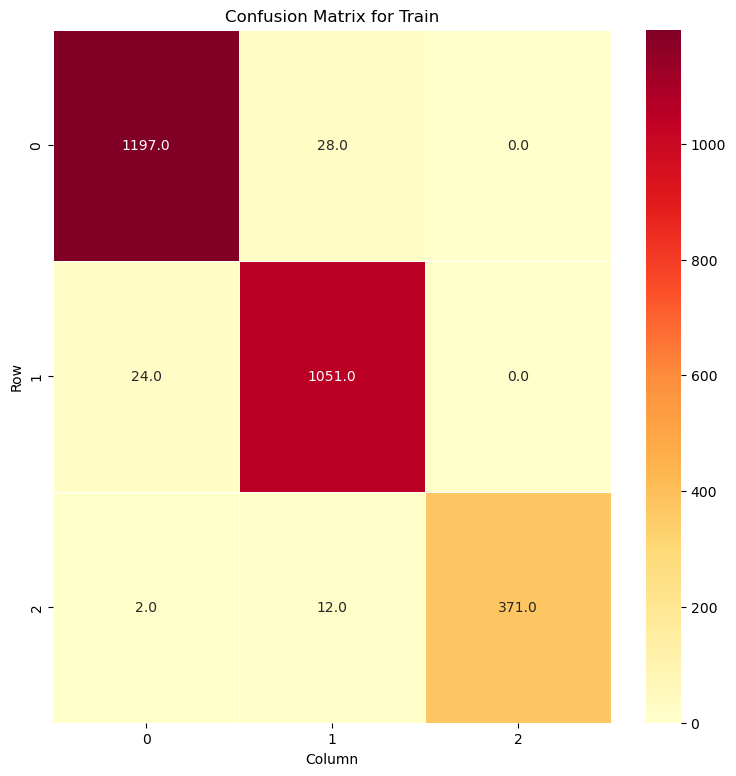

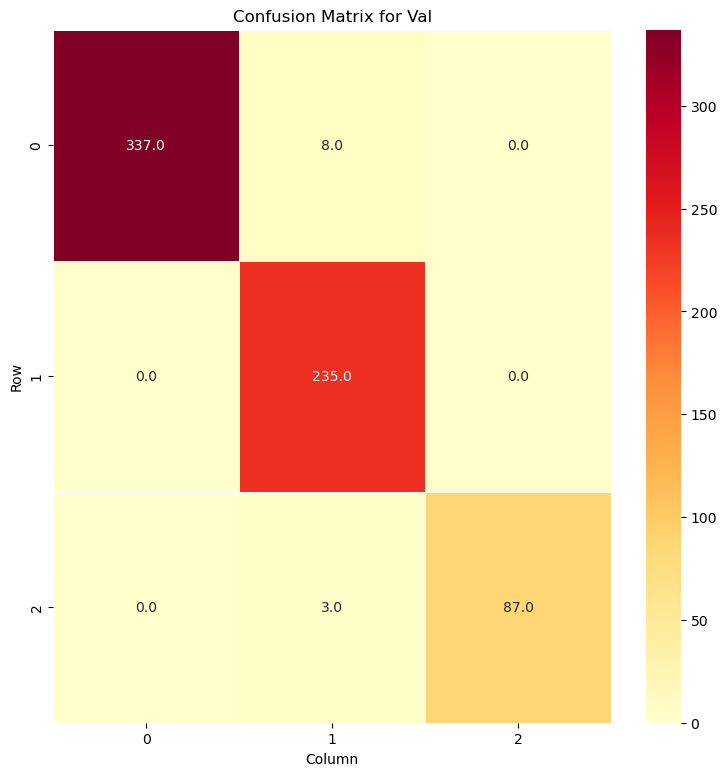

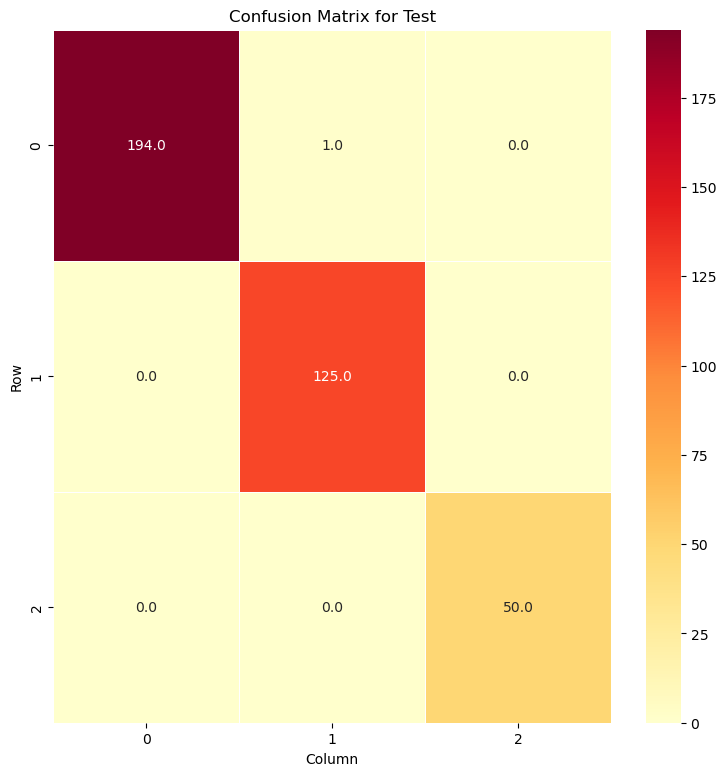

In [33]:
heat_map_train, heat_map_val, heat_map_test = heat_map_visualization(trained_models)

In [34]:
def convert_to_np(cuda_list):
    temp_c = [l.cpu().numpy() for l in cuda_list]
    return np.array(temp_c)

In [35]:

def plot_acc_loss(train_acc, train_loss, val_acc, val_loss, test_acc, test_loss):
    fig, axs = plt.subplots(2)

    # Subplot for accuracy
    axs[0].plot(np.arange(0, len(train_acc), 1), convert_to_np(train_acc))
    axs[0].plot(np.arange(0, len(val_acc), 1), convert_to_np(val_acc))
    axs[0].plot(np.arange(0, len(test_acc), 1), convert_to_np(test_acc))
    axs[0].legend(["Train Accuracy", "Validation Accuracy","Test Accuracy"])
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")

    # Subplot for loss
    axs[1].plot(np.arange(0, len(train_loss), 1), train_loss)
    axs[1].plot(np.arange(0, len(val_loss), 1), val_loss)
    axs[1].plot(np.arange(0, len(test_loss), 1), test_loss)
    axs[1].legend(["Train Loss", "Validation Loss", "Test Loss"])
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss")

    # Display the plot
    plt.tight_layout()
    plt.show()

For fold 0


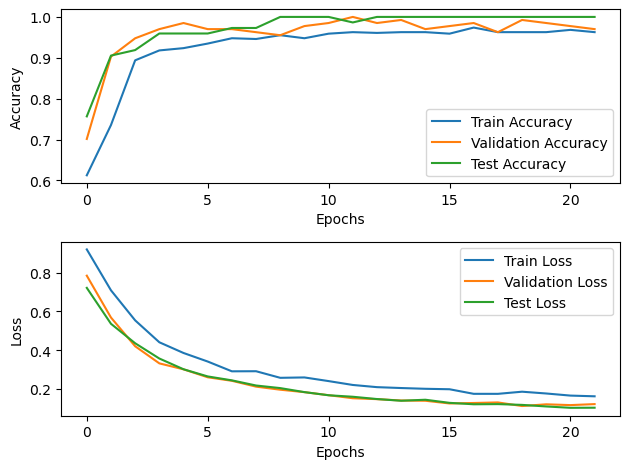

For fold 1


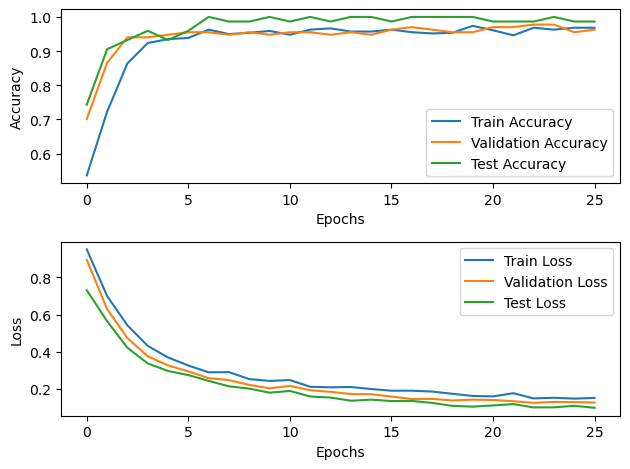

For fold 2


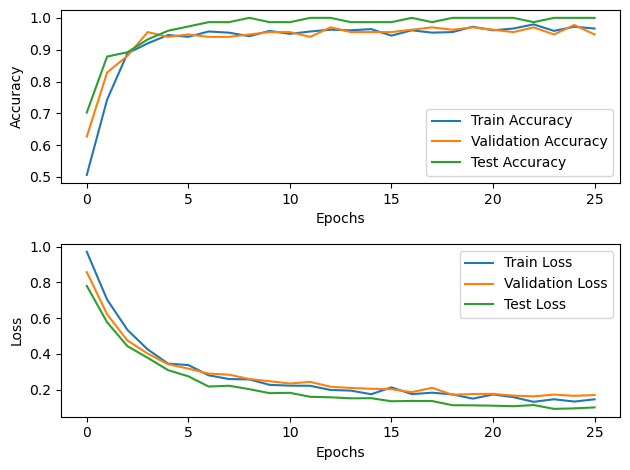

For fold 3


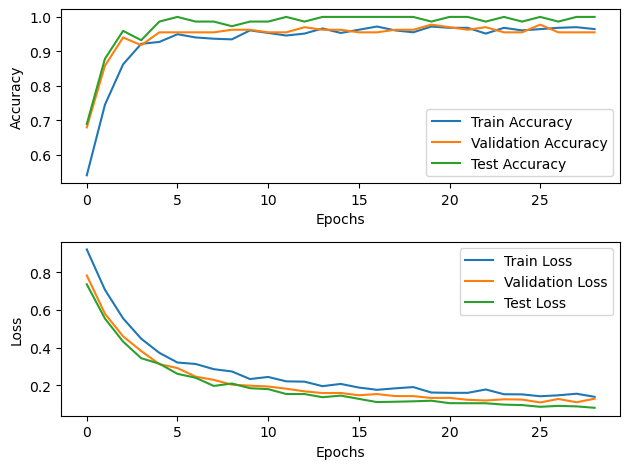

For fold 4


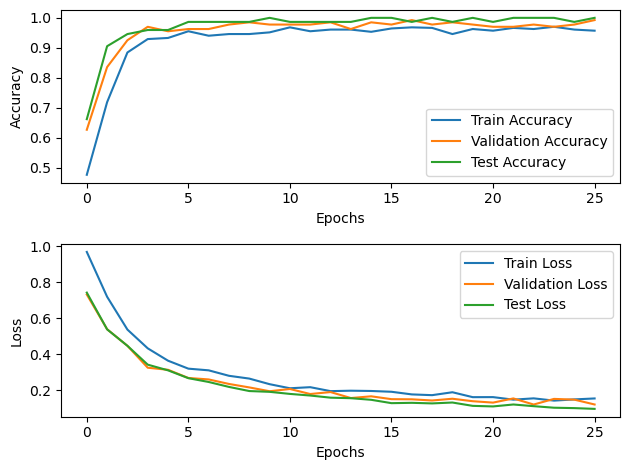

In [36]:
for fold in range(n_folds):
    print("For fold {}".format(fold))
    train_acc, train_loss, val_acc, val_loss, test_acc, test_loss = models_output[fold][0], models_output[fold][1], models_output[fold][2], models_output[fold][3], models_output[fold][4], models_output[fold][5]
    plot_acc_loss(train_acc, train_loss, val_acc, val_loss, test_acc, test_loss)

In [37]:
import numpy as np

def metrics_from_confusion_matrix(confusion_matrix):
    num_classes = confusion_matrix.shape[0]
    # Initialize arrays to store TP, FP, FN, TN
    true_positives = np.zeros(num_classes)
    false_positives = np.zeros(num_classes)
    false_negatives = np.zeros(num_classes)
    true_negatives = np.zeros(num_classes)

    for i in range(num_classes):
        true_positives[i] = confusion_matrix[i, i]
        false_negatives[i] = np.sum(confusion_matrix[i, :]) - true_positives[i]
        false_positives[i] = np.sum(confusion_matrix[:, i]) - true_positives[i]
        true_negatives[i] = np.sum(confusion_matrix) - (true_positives[i] + false_positives[i] + false_negatives[i])

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1 = 2 * (precision * recall) / (precision + recall)

    # Calculate macro and weighted averages
    macro_f1 = np.mean(f1)
    weighted_f1 = np.sum(f1 * np.sum(confusion_matrix, axis=1)) / np.sum(confusion_matrix)

    metrics = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1
    }

    for i in range(num_classes):
        print("Class {}".format(i))
        print("Precision = {}, recall = {}, f1 = {}\n".format(precision[i], recall[i], f1[i]))




In [38]:
print("The metrics for train process:\n")
train_metrics = metrics_from_confusion_matrix(heat_map_train)

The metrics for train process:

Class 0
Precision = 0.9787408013082584, recall = 0.9771428571428571, f1 = 0.9779411764705882

Class 1
Precision = 0.9633363886342805, recall = 0.9776744186046512, f1 = 0.9704524469067406

Class 2
Precision = 1.0, recall = 0.9636363636363636, f1 = 0.9814814814814815



In [39]:
print("The metrics for val process:\n")
val_metrics = metrics_from_confusion_matrix(heat_map_val)

The metrics for val process:

Class 0
Precision = 1.0, recall = 0.9768115942028985, f1 = 0.9882697947214076

Class 1
Precision = 0.9552845528455285, recall = 1.0, f1 = 0.9771309771309772

Class 2
Precision = 1.0, recall = 0.9666666666666667, f1 = 0.983050847457627



In [40]:
print("The metrics for test process:\n")
test_metrics = metrics_from_confusion_matrix(heat_map_test)

The metrics for test process:

Class 0
Precision = 1.0, recall = 0.9948717948717949, f1 = 0.9974293059125964

Class 1
Precision = 0.9920634920634921, recall = 1.0, f1 = 0.9960159362549801

Class 2
Precision = 1.0, recall = 1.0, f1 = 1.0

